In [1]:
import csv
from enum import Enum
import math

# Plotting 
%matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import matplotlib.pyplot as plt
# from matplotlib.collections import Poly3DCollection # https://stackoverflow.com/questions/10599942/drawing-a-rectangle-or-bar-between-two-points-in-a-3d-scatter-plot-in-python-and
# and https://stackoverflow.com/questions/37585340/plotting-3d-polygons-in-python-3

import numpy as np
from numpy.random import PCG64
import time

# import my own libraries
from arm import *               # import the arm state library
from camera import *            # import the simulated vision system
from fruitTreeCreator import *  # import the library that creates the array with fruit location + other info
from scheduler import *         # import the scheduler functions 
from simulation_config import * # import the JSON creation file so that it can be read back to set parameters
from trajectory import *        # import the trajectory generation "library" that I'm writing

import json # configuration file encode and decode
# see https://realpython.com/python-json/#decoding-custom-types

# Testing and Debugging
# Example: https://stackoverflow.com/questions/40172281/unit-tests-for-functions-in-a-jupyter-notebook
import unittest             # docs https://docs.python.org/3/library/unittest.html 
import pdb #; pdb.set_trace() # docs https://docs.python.org/3/library/pdb.html

# interesting/useful websites
# talks about implementing robot simulator: https://www.toptal.com/robotics/programming-a-robot-an-introductory-tutorial  
#    said robot simulator code: https://github.com/nmccrea/sobot-rimulator/blob/v1.0.0/models/supervisor.py

In [2]:
######## RANDOM SEED GENERATOR ########
'''Use only when a new seed is needed'''
# https://numpy.org/devdocs/reference/random/index.html

# from numpy.random import PCG64, SeedSequence

# sq1 = np.random.SeedSequence()

# seed = sq1.entropy

# print(seed)

### How to use seeds
## ss = SeedSequence(seed)
## print('seed = {}'.format(ss.entropy))
## bg = PCG64(ss)

######### GENERATED SEEDS ##########
## FRUIT TREE CREATOR SEEDS ##
# self.x_fr - 37428395352013185889194479428694397783 
# self.y_fr - 13250124924871709375127216220749555998
# self.z_fr - 165440185943501291848242755689690423219
# self.x_fake - 264090507119924891834746017829286837587
# self.y_fake - 307175982666302731017951161793326853810
# self.z_fake - 202459549346992037879433717317760015805


'Use only when a new seed is needed'

In [3]:
def step(t, dt):
    t = t + dt
    return t

In [4]:
class drawRobot(object):
    def __init__(self):
        self.a = 0
        
    def drawRect(self, q_curr, width_v, length_v):

        xl  = q_curr[0] + width_v / 2  # left x coordinate
        xr  = q_curr[0] - width_v / 2  # right x coordinate

        yf  = q_curr[1] - length_v / 2 # front
        yb  = q_curr[1] + length_v / 2 # back

        verts = []

        xs = [xr, xl, xl, xr, xr]  # each box has 4 vertices, give it 5 to close it, these are the x coordinates
        ys = [yf, yf, yb, yb, yf]  # each box has 4 vertices, give it 5 to close it, these are the y coordinates
        z_axis = [0, 0, 0, 0, 0]

        verts = [list(zip(xs, ys, z_axis))]

        poly = Poly3DCollection(verts, facecolors="blue", closed = False)
        ax.add_collection3d(poly, zs=[z_axis[0]] * len(verts), zdir='z')
        
        
    def drawFrame(self, left_edge, back_edge, front_edge, z_edges_f):
        xl  = left_edge  # back x coordinate
        
        yf  = front_edge # front y coordinate
        yb  = back_edge  # back y coordinate

        zt  = z_edges_f[0]  # top z coordinate
        zb  = z_edges_f[1]  # bottom z coordinate

        verts = []
        
        xs = [xl, xl, xl, xl, xl]
        ys = [yf, yb, yb, yf, yf]  # each box has 4 vertices, give it 5 to close it, these are the x coordinates
        z_axis = [zt, zt, zb, zb, zt]  # each box has 4 vertices, give it 5 to close it, these are the y coordinates
        
        verts = [list(zip(xs, ys, z_axis))]
        
        poly = Poly3DCollection(verts, closed = False, alpha=0.25)
        poly.set_facecolor("grey")  # the transparency setting (alpha) is overriden by facecolor otherwise
        ax.add_collection3d(poly, zs=[z_axis[0]] * len(verts), zdir='z')
        
    def drawArmCylinder(self, center_y, center_z, arm_start, arm_end):
        # see second answer https://stackoverflow.com/questions/26989131/add-cylinder-to-plot
        radius = 0.2 # set arbitrarily 
        
        x     = np.linspace(arm_start, arm_end, 3)
        theta = np.linspace(0, 2*np.pi, 3)
        
        theta_grid, x_grid = np.meshgrid(theta, x)
        
        y_grid = radius*np.cos(theta_grid) + center_y
        z_grid = radius*np.sin(theta_grid) + center_z
        
        return x_grid,y_grid,z_grid
            

In [5]:
def vehicleStep(q_curr, v, dt):
    # for now it's constant velocity  
    q_new = np.array([q_curr[0] + v[0]*dt, q_curr[1] + v[1]*dt])
    return q_new

In [6]:
class csvRead(object):
    def __init__(self):
        #################### CLASS VARIABLES ####################
        
        # open CSV file and populate fruits on grid
        x_fr = []
        y_fr = []
        z_fr = []

        # with open('Applestotheleft.csv', newline='') as csvfile:
        #     spamreader = csv.reader(csvfile, delimiter=',', quotechar='|')
        #     for row in spamreader:
        #         x_fr.append(float(row[0]))
        #         y_fr.append(float(row[1]))
        #         z_fr.append(float(row[2]))

        with open('Applestotheright.csv', newline='') as csvfile:
            spamreader = csv.reader(csvfile, delimiter=',', quotechar='|')
            for row in spamreader:
                x_fr.append(float(row[0]))
                y_fr.append(float(row[1]))
                z_fr.append(float(row[2]))

        self.x_fruit = np.array(x_fr)
        self.y_fruit = np.array(y_fr)
        self.z_fruit = np.array(z_fr)
        picked  = np.zeros(len(self.x_fruit))
        arm     = np.full(len(self.x_fruit), np.inf) # will indicate which arm is set to this goal 

        # need a matrix to sort x, y, and z based on the y-axis (to know what fruit show up earlier)
        fruit = np.stack([x_fr, y_fr, self.z_fruit, picked, arm])

        rowIndex = 1 # sort based on y-axis
        self.sortedFruit = fruit[ :, fruit[rowIndex].argsort()]


In [7]:
## Set Flag values
class spaceConf(Enum):
    '''Flag values for if the workspace in each row is individual or shared'''
    INDIVIDUAL = 0
    SHARED     = 1
    
    
class calendar(Enum):
    '''Flag values for the type of scheduler to use, name seems like a bad idea :P'''
    SINGLE_FRUIT = 0
    EDF          = 1 # Earliest Deadline First, batch
    

class treeCreation(Enum):
    '''Flags values for the type of data being used as fruit coordinates'''
    CSV_RAJ  = 0
    SYN_LINE = 1
    UNIFORM  = 2
    

class noiseMaker(Enum):
    '''Flags values for the type of noise'''
    TURN_OFF = 0
    TURN_ON  = 1
    
    
class reality(Enum):
    '''Flag values determining how many fruit are real and how many are fake in the simulation'''
    TURN_OFF  = 0
    DENSITY   = 1

In [8]:
###### create JSON configuration file to read from #####
# init function
json_data = simulation_config()

# creates the data file based on default values 
json_data.convertJSON()

# load the json file
data = json.load(open("data.json"))

###### Parameter settings from the JSON configuration file ######

# fruit row depth, in ft  -- x-axis
fruit_row_ed   = data['orchard']['x']['start']  # how far the vehicle will be from the edges of the tree
fruit_row_tk   = data['orchard']['x']['end']    # how far the arms can reach into the canopy/ where the trunk is

# fruit row length, in ft -- y-axis
fruit_row_st   = data['orchard']['y']['start']  
fruit_row_end  = data['orchard']['y']['end'] 

# fruit row height, in ft -- z-axis
fruit_row_bt   = data['orchard']['z']['start']
fruit_row_tp   = data['orchard']['z']['end'] 

# values for fruit density (currently supports only one value overall)
rho_real       = data['orchard']['rho_real']
rho_fake       = data['orchard']['rho_fake']

# decide on the number of arms and rows
num_arms       = data['vehicle']['num_arms']      # set number of arms on robot, will determine the length of the robot (for now)
num_row        = data['vehicle']['num_rows']      # set the number of rows of arms 

# arm's max velocity and acceleration values apparently in ft/s
max_v          = data['arms']['max_v']
max_a          = data['arms']['max_a']

# vehicle's velocity (constant), in ft/s
v_vx           = data['vehicle']['v_vx'] 
v_vy           = data['vehicle']['v_vy']

# number of goals the semionline scheduler will look for
n_goals        = data['num_goals']                

# when working with the fruit ribbon, how high above the conveyors will the ribbon be
ribbon_z       = data['ribbon_z']

# decide if the arms are in individual or shared spaces
space_config   = spaceConf(data['space_config'])

# decide on the type of scheduler
appointment    = calendar(data['appointment'])

# decide what fruit distribution to use to create fruit coordinates
data_config    = treeCreation(data['data_config'])

# decide if fake fruit will be added
existance      = reality(data['existance'])

# decide if noise should be added and the distribution
noise_level    = noiseMaker(data['noise_level'])



Would you like to save in seperate file? (y or n)
Invalid answer, default set to not save the file.


In [9]:
####### Vehicle Init Values for parameter setting #######
# configure the vehicle

# create the vehicle speed array 
v_v = np.array([v_vx,v_vy])  # in ft, constant velocity only in y-axis

# make the arm take up space within the space (slowly added)
column_width = 0.2               # width of column holding the arm in place

# calculate the height of the frame based on number of rows, height of orchard, and add column width to make sure all
# fruit can be reached
frame_height = (fruit_row_tp - fruit_row_bt + 2*column_width) / num_row # if the rows are evenly spaced

# configure the arm's space, length added to vehicle per arm in the y-direction
if space_config == spaceConf.INDIVIDUAL:
    frame_width  = 3.                
elif space_config == spaceConf.SHARED:
    frame_width  = 3.
#     frame_width  = 1.9

width_v  = 1.                    # vehicle width (x-dir, parallel to arms going into canopy) (only for plotting)
length_v = frame_width*num_arms  # vehicle length (y-dir parallel to row of trees)

##################### Based on Flags #####################

# initializes required variables based on the distribution creation method
if data_config != treeCreation.CSV_RAJ: 
    q_v = np.array([fruit_row_ed-1.0/2-0.3, fruit_row_st]) 
    # init a z-coordinate list of where a fruit ribbon will be placed on each row
    fruit_lines = []
    # if using the line distribution, this will set the z height for each line
    for n in range(num_row):
        fruit_lines.append(n*frame_height + ribbon_z) # in ft
        
    # initialize the synthetic fruit distribution creator
    fruit = fruitTreeCreator([fruit_row_st,fruit_row_end]) 
    # settings for an angle offset if the tree data has the fruit set at a diagonal
    arm_offset = 0.
    # create list for fruit and fake fruit 
    fruit_density = []
    fake_density  = []
    
    for n in range(num_row):
        # set fruit density and percent of fake fruit to add (will have to change later to add sections
        # with different densities)
        fruit_density.append([rho_real])  # in fruit/ft^3 (unless using LINE, then it's fruit/ft^2)
        if existance == reality.DENSITY:
            fake_density.append([rho_fake])
        else:
            fake_density.append([0.0])

    
elif data_config == treeCreation.CSV_RAJ:
    q_v = np.array([4.5,7.]) # fruits are in very specific locations
    # CSV fruit are diagonally placed (fix that later?)
    v_v = np.array([0.01,0.05])  # in ft, constant velocity   => for single fruit got almost 100% fruit at 0.007m/s with 0.73s/fruit (too slow)
    # use Raj's digitized fruit from real trees
    fruit = csvRead()  
    # settings for an angle offset if the tree data has the fruit set at a diagonal
    arm_offset = 0.75 / (num_row-1)

    
    
if data_config == treeCreation.SYN_LINE:  
    # create synthetic fruit data in a line to test the robot when fruit are set at one specific height
    for r in range(num_row):
        fruit.fruitLine(num_row, fruit_density[r], [fruit_row_ed,fruit_row_tk], fruit_lines[r], fake_density[r])
#     fruit.fruitLine(fruit_lines)
    fruit.fruitTreeOut()
    
elif data_config == treeCreation.UNIFORM:
    # test the robot when there is variation in distance between fruit
#     fruit.fruitUniform()
    for r in range(num_row):
        fruit.fruitUniform(num_row,fruit_density[r],[fruit_row_ed,fruit_row_tk],[fruit_row_bt,fruit_row_tp], fake_density[r])
    fruit.fruitTreeOut()
        
    

In [10]:
####################### init vehicle lists for data analysis #######################
# used to plot the vehicle
qv0 = []
qv1 = []

##################### init environment #####################
# end of the row (when the back of vehicle reaches this point it should stop)
end_row = fruit_row_end + width_v
t       = []         # 'global' time
t_step  = 0.
dt      = 0.01      # 'global' time step size
runs    = 0

# used to plot basic outlines of the robot for better visualization
dr = drawRobot()

# create empty list which will save arm states for plotting and data processing
arm_states = [] 

######################## init camera #######################
row_picture = []

for rows in range(num_row): # one "camera" object per row on vehicle
    p = camera(length_v, rows, frame_height)
    row_picture.append(p)
    
    
######################### init arms ########################

# array of arm object setup
a = np.ndarray((num_row,num_arms), dtype=object) 

# setup for arm initialization
arm0start_y = q_v[1] - (length_v - frame_width)/2  # arm starting position in the y-dir
q_a_new = np.array([0.,0.,0.])                     # used as a temporary value while calculating arm init positions
            
# initialize the arm objects in a matrix set for each row and for the number of arms in  said row
for rows in range(num_row):       
    for count in range(num_arms):      
        # calculate where each new arm should go
        # if fruit's in a diagonal, get the bottom arms closer to the fruit
        # the 0.3 is the zero starting point since it will never be exactly zero if they're extending cylinders
        q_a_new[0] = q_v[0] + 0.3 + ((num_row-1)*arm_offset - arm_offset*rows)
        q_a_new[1] = arm0start_y + frame_width*count # places the arms either in their space or far from each other
        q_a_new[2] = row_picture[rows].row_mid   # place it in the already calculated middle of the row
        # last one this makes sure it matches the "camera" object's z-location 
        
        # initialize the new arm
        x = arm(q_a_new, q_v, count, num_arms, frame_width, frame_height, column_width, rows, max_v, max_a, space_config.value)

        # add the arm to the a-list     
        a[rows,count] = x

# for plotting data
left_edge  = []
right_edge = []
front_edge = []
back_edge  = []


###################### init scheduler ######################
goal = np.zeros(3) # does this go here? it's an empty array for the goal values for each arm...

s = scheduler(n_goals, num_row, num_arms, max_v, max_a) 
# make a scheduler function that sets n_goals only if it's synthetic data

In [11]:
### MAIN LOOP CODE ###

## start timer to see how long code takes to execute
start_time = time.time()

##### while loooop!
while(q_v[1] < end_row):
    # env.step
    t_step = step(t_step, dt)
    t.append(float(t_step))    
    
    # vehicle.step 
    q_v = vehicleStep(q_v, v_v, dt) # calculate "instantaneous" location
    
    
    # env.obs / camera... FLASH!
    for rows in range(num_row):
        row_picture[rows].cameraStep(end_row, q_v[1], fruit.sortedFruit) # resulting in a B-Tree of index/coordinates in world frame  
    
    
    if (noise_level == noiseMaker.TURN_ON):
        # add some noissse! (to the fruit locations)
        noise_level = noiseMaker.TURN_OFF # but not right now
        
    # scheduler setting
    if appointment == calendar.SINGLE_FRUIT:
        s.singleFruitScheduler(num_row, num_arms, a, row_picture, fruit, t_step)
        
    elif appointment == calendar.EDF:
        if runs % 100 == 0: # don't want to run the scheduler every millisecond
            s.edfScheduler(a, row_picture, fruit, v_v, space_config.value) 
        # go through the list and give each arm a goal
        for rows in range(num_row):
            # give each free arm in that row a goal
                for arm_free in range(num_arms):
                    if a[rows,arm_free].free == 1:
                        # need to check if there are goals
                        if (not s.goal_queue[rows, arm_free].empty()):
                            goal_new = s.goal_queue[rows, arm_free].get()
                            # give the arm the index so that it can set it back to 0 if it does not reach it
                            a[rows,arm_free].goal_index = goal_new
                            # set the new goal
                            a[rows,arm_free].setGoal(fruit.sortedFruit[0:3,goal_new], t_step) 

    
    # have each arm take a step
    for rows in range(num_row):
        for arm2step in range(num_arms):
            q_a = a[rows,arm2step].armStep(v_v, a[rows,:], dt, t_step, fruit, row_picture)
    
    # plotting data     
    qv0.append(float(q_v[0]))
    qv1.append(float(q_v[1]))
    
    left_edge.append(float(q_v[0]))  # set at the center of the vehicle in case the arm is set as diagonal to rach farther fruit
    front_edge.append(float(a[0,0].y_edges_f[0]))
    back_edge.append(float(a[0,0].y_edges_f[1]))
    
    arm_index = 0
    arm_list  = []
    
    # compile at which state each arm ends the loop to add to plot later
    for rows in range(num_row):
        for arm2state in range(num_arms):
            arm_list.append([arm_index, a[rows, arm2state].stateFLAG])
            arm_index += 1
    
    # save arm states 
    arm_states.append(arm_list)
               
    runs+=1


prog_time = time.time() - start_time

start, end, start velocity: -0.2 0.988814429908131 0.0
start, end, start velocity: 3.0 0.0015401856941155145 0.0
start, end, start velocity: 1.5666666666666667 0.6442726013808399 0.0
start, end, start velocity: 0.988814429908131 -0.2 0.0
start, end, start velocity: 0.6442726013808399 0.0 0.0
start, end, start velocity: -0.2 1.0705508498659766 0.0
start, end, start velocity: 0.0 0.07059252397484395 0.0
start, end, start velocity: 1.5666666666666667 1.448549770617991 0.0
start, end, start velocity: 1.0705508498659766 -0.2 0.0
start, end, start velocity: 1.448549770617991 0.0 0.0
start, end, start velocity: -0.2 0.7134600028870357 0.0
start, end, start velocity: -3.0 0.09347548702352548 0.0
start, end, start velocity: 1.5666666666666667 0.09331199847688876 0.0
start, end, start velocity: 0.7134600028870357 -0.2 0.0
start, end, start velocity: 0.09331199847688876 0.0 0.0
start, end, start velocity: -0.2 0.9275786991267165 0.0
start, end, start velocity: 0.0015401856941155145 0.363791579983

start, end, start velocity: 0.34187217251563257 -0.2 0.0
start, end, start velocity: 7.770492989453418 6.266666666666667 0.0
start, end, start velocity: -0.2 1.1214898992142712 0.0
start, end, start velocity: 3.7287983395980966 4.053928446024418 0.0
start, end, start velocity: 6.266666666666667 6.746552842238561 0.0
start, end, start velocity: 1.1214898992142712 -0.2 0.0
start, end, start velocity: 6.746552842238561 6.266666666666667 0.0
start, end, start velocity: -0.2 0.9301467788527811 0.0
start, end, start velocity: 3.7743270247923233 4.061075409011295 0.0
start, end, start velocity: 6.266666666666667 8.443039579565038 0.0
start, end, start velocity: 0.9301467788527811 -0.2 0.0
start, end, start velocity: 8.443039579565038 6.266666666666667 0.0
start, end, start velocity: -0.2 0.7134600028870357 0.0
start, end, start velocity: -3.0 0.09347548702352548 0.0
start, end, start velocity: 1.5666666666666667 0.09331199847688876 0.0
start, end, start velocity: -0.2 1.0705508498659766 0.0
s

start, end, start velocity: 5.704180840132493 3.1333333333333337 0.0
start, end, start velocity: 1.594161364233623 0.0 0.0
start, end, start velocity: -0.2 1.1113679920268371 0.0
start, end, start velocity: 0.24227153263539802 0.44259086638696876 0.0
start, end, start velocity: 6.266666666666667 6.7199005375494725 0.0
start, end, start velocity: -0.2 0.4015306509311268 0.0
start, end, start velocity: 0.3025149838541771 0.48520953461020366 0.0
start, end, start velocity: 0.0 0.33112924772160846 0.0
start, end, start velocity: 0.37277545861774863 -0.2 0
start, end, start velocity: -0.2 0.4798721356020456 0.0
start, end, start velocity: 2.1629454960632253 4.575463918246092 0.0
start, end, start velocity: 5.049180840132507 3.631912059262589 0.0
start, end, start velocity: 0.4798721356020456 -0.2 0.0
start, end, start velocity: 3.631912059262589 3.1333333333333337 0.0
start, end, start velocity: -0.2 1.2489515973459109 0.0
start, end, start velocity: 1.1999029514250263 0.7021499600594644 0.

start, end, start velocity: 0.9867435513513846 -0.2 0
start, end, start velocity: 1.2795325699291678 -0.2 0
*** Is it just idle? ***
*** BAD FLAG: 0  ***
start, end, start velocity: -0.1999999999997793 0.9705087947550683 0.0
start, end, start velocity: 2.2806810321274837 2.5520073972219754 0.0
start, end, start velocity: 6.81166666666691 8.205620481434993 0.0
start, end, start velocity: -0.19999999999991408 0.6024247393671185 0.0
start, end, start velocity: 0.44653526101080293 1.2490089653015262 0.0
start, end, start velocity: 3.133333333333792 5.278180961329167 0.0
start, end, start velocity: 4.646672336501361 3.1333333333333337 0.0
start, end, start velocity: -0.19999999999979595 1.0421590679531043 0.0
start, end, start velocity: 2.8712391552628658 5.057233970860303 0.0
start, end, start velocity: 4.471672336501356 5.443087634688753 0.0
start, end, start velocity: 1.0421590679531043 -0.19999999999979595 0.0
start, end, start velocity: 5.443087634688753 3.1333333333333337 0.0
start, e

*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
start, end, start velocity: -0.19999999999988155 0.988814429908131 0.0
start, end, start velocity: 1.518679885275032 0.0015401856941155145 0.0
start, end, start velocity: 0.0010000000001573355 0.6442726013808399 0.0
start, end, start velocity: 0.988814429908131 -0.19999999999988155 0.0
start, end, start velocity: 0.6442726013808399 0.0 0.0
start, end, start velocity: -0.19999999999980217 0.9239126619330069 0.0
start, end, start velocity: 1.68305230236241 2.2581427342382248 0.0
start, end, start velocity: 6.266666666666868 7.721067482760586 0.0
start, end, start velocity: 0.7135859942894452 -0.2 0
start, end, start velocity: -0.19999999999989548 0.43857463752797393 0.0
start, end, start velocity: 2.5129389907941815 2.750417356739418 0.0
start, end, start velocity: 4.873455155054995e-13 0.059907321827529 0.0
start, end, start velocity: 1.2139785664410587 -0.2 0
start, end, star

start, end, start velocity: 1.0976066545442884 -0.2 0
start, end, start velocity: -0.2 1.1214898992142712 0.0
start, end, start velocity: 3.8627983395981866 4.053928446024418 0.0
start, end, start velocity: 6.266666666666667 6.746552842238561 0.0
start, end, start velocity: 0.5824888684277377 -0.2 0
start, end, start velocity: 3.21942638400283 3.1333333333333337 0.0
start, end, start velocity: -0.2 0.5057984107758069 0.0
start, end, start velocity: 4.082228772981016 4.275297003763024 0.0
start, end, start velocity: 3.133410970292232 6.135268277106924 0.0
start, end, start velocity: 7.480342389755431 6.266666666666667 0.0
start, end, start velocity: -0.2 1.2441413091398432 0.0
start, end, start velocity: 1.8669991265685073 2.2945582684649106 0.0
start, end, start velocity: 0.0 2.8164238400952355 0.0
start, end, start velocity: 7.074360317275597 6.266666666666667 0.0
start, end, start velocity: -0.2 0.5830638161262494 0.0
start, end, start velocity: 2.503058268465004 2.8773057633423442 0

start, end, start velocity: -0.2 1.0421590679531043 0.0
start, end, start velocity: 4.615217593465905 5.057233970860303 0.0
start, end, start velocity: 4.795594636632889 5.443087634688753 0.0
start, end, start velocity: -0.2 1.2477891983151859 0.0
start, end, start velocity: 4.422717593465901 0.06349522470232849 0.0
start, end, start velocity: 3.1333333333333337 5.7530461940647335 0.0
*** Is it just idle? ***
*** BAD FLAG: 0  ***
start, end, start velocity: -0.2 1.2489515973459109 0.0
start, end, start velocity: 4.422717593465901 0.7021499600594644 0.0
start, end, start velocity: 3.1333333333333337 3.738885877472655 0.0
*** Is it just idle? ***
*** BAD FLAG: 0  ***
start, end, start velocity: -0.2 1.2609223079163208 0.0
start, end, start velocity: 4.422717593465901 1.2903568515575086 0.0
start, end, start velocity: 3.1333333333333337 5.271896891132122 0.0
*** Is it just idle? ***
*** BAD FLAG: 0  ***
start, end, start velocity: -0.2 1.0423496841478679 0.0
start, end, start velocity: 4.

start, end, start velocity: 0.6377903156744081 0.0 0.0
start, end, start velocity: 5.8736255256854255 3.1333333333333337 0.0
start, end, start velocity: 1.0662092073387248 0.0 0.0
start, end, start velocity: 0.5849999999999894 1.1443090293625449 0.0
start, end, start velocity: 5.294350190237092 6.930270621372955 0.0
start, end, start velocity: 6.893855793616388 7.826131773978173 0.0
start, end, start velocity: 1.1443090293625449 0.5849999999999894 0.0
start, end, start velocity: 7.826131773978173 6.266666666666667 0.0
start, end, start velocity: 0.40499999999998926 0.9301467788527811 0.0
start, end, start velocity: 4.832548704472153 4.061075409011295 0.0
start, end, start velocity: 6.914473382223158 8.443039579565038 0.0
start, end, start velocity: 0.9301467788527811 0.40499999999998926 0.0
start, end, start velocity: 8.443039579565038 6.266666666666667 0.0
start, end, start velocity: -0.2 0.7326595220954404 0.0
start, end, start velocity: 0.44506045419111234 0.013231177355646495 0.0
s

start, end, start velocity: 1.2780474927688021 -0.2 0
start, end, start velocity: 0.901835350656473 -0.2 0
start, end, start velocity: -0.2 0.5457839578104258 0.0
start, end, start velocity: 0.5540604541911064 5.28024633733051 0.0
start, end, start velocity: 6.266666666666667 6.5196730359688475 0.0
start, end, start velocity: 0.4997060332473626 -0.2 0
start, end, start velocity: 1.0156850576042435 0.0 0.0
start, end, start velocity: 3.6943679854886486 3.1333333333333337 0.0
start, end, start velocity: 1.2012549574898326 -0.2 0
start, end, start velocity: 0.424801537732697 -0.2 0
start, end, start velocity: 2.2942332360916518 0.0 0.0
start, end, start velocity: 3.876038785079878 3.1333333333333337 0.0
start, end, start velocity: 1.0508077480137459 -0.2 0
start, end, start velocity: -0.2 1.1043927242452316 0.0
start, end, start velocity: 5.73830479174253 3.5308336408349876 0.0
start, end, start velocity: 3.1333333333333337 5.0131989268237 0.0
*** Is it just idle? ***
*** BAD FLAG: 0  ***

start, end, start velocity: 1.0016554889011402 -0.2 0
start, end, start velocity: -0.19999999999968304 0.7309996393429155 0.0
start, end, start velocity: 6.403358838860451 6.438682755161102 0.0
start, end, start velocity: 3.1333333333338436 5.217628995444201 0.0
start, end, start velocity: 1.2526317151173947 -0.2 0
start, end, start velocity: -0.19999999999925394 0.7331339619299155 0.0
start, end, start velocity: 3.146048906066818 3.5621704982949725 0.0
start, end, start velocity: 5.160062915149366e-13 0.09332848142348737 0.0
start, end, start velocity: -0.19999999999955026 0.7849797694430798 0.0
start, end, start velocity: 6.762251103567508 6.123540138208478 0.0
start, end, start velocity: 6.266666666667415 6.305072792630488 0.0
*** Is it just idle? ***
*** BAD FLAG: 0  ***
start, end, start velocity: -0.19999999999955026 1.0791592526096054 0.0
start, end, start velocity: 6.762251103567508 6.472429225421836 0.0
start, end, start velocity: 6.266666666667415 7.995218725642143 0.0
*** Is

start, end, start velocity: -0.1999999999997341 0.4495722371582835 0.0
start, end, start velocity: 4.531816747861737 0.20757537346273447 0.0
start, end, start velocity: 3.133333333334707 4.588762015993937 0.0
start, end, start velocity: -0.19999999999964208 0.8837804035093957 0.0
start, end, start velocity: 6.63438684551332 4.601656203027382 0.0
start, end, start velocity: 3.1333333333349254 4.7955946366325914 0.0
*** Is it just idle? ***
*** BAD FLAG: 0  ***
start, end, start velocity: -0.19999999999964208 0.8837804035093957 0.0
start, end, start velocity: 6.63438684551332 4.601656203027382 0.0
start, end, start velocity: 3.1333333333349254 4.7955946366325914 0.0
*** Is it just idle? ***
*** BAD FLAG: 0  ***
start, end, start velocity: -0.19999999999964208 1.0421590679531043 0.0
start, end, start velocity: 6.63438684551332 5.057233970860303 0.0
start, end, start velocity: 3.1333333333349254 5.443087634688753 0.0
start, end, start velocity: 0.5273121631649965 -0.2 0
start, end, start v

*** Is it just idle? ***
*** BAD FLAG: 0  ***
start, end, start velocity: -0.1999999999993612 0.6240269550553372 0.0
start, end, start velocity: 4.472733970860867 5.53588135003317 0.0
start, end, start velocity: 3.838333333334572 4.925667446116334 0.0
start, end, start velocity: -0.199999999999734 0.6879502267718833 0.0
start, end, start velocity: 8.15054090258458 8.118197711272995 0.0
start, end, start velocity: 6.26666666666798 7.513213806616757 0.0
start, end, start velocity: -0.1999999999996984 0.41373701814478786 0.0
start, end, start velocity: 5.194295857503811 5.4394543183183375 0.0
start, end, start velocity: 6.43670338383584e-13 0.7874893841223443 0.0
start, end, start velocity: 1.242305343553865 -0.2 0
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
start, end, start velocity: -0.1999999999996676 1.2609223079163208 0.0
start, end, start velocity: 1.8005753734649739 1.2903568515575086 0.0
start, end, start velocit

start, end, start velocity: 0.9674333462467566 -0.2 0
start, end, start velocity: -0.19999999999945822 1.2429445775578638 0.0
start, end, start velocity: 8.80459334408148 8.990348769417869 0.0
start, end, start velocity: 6.266666666667037 6.812093855590499 0.0
start, end, start velocity: 1.2429445775578638 -0.19999999999945822 0.0
start, end, start velocity: 6.812093855590499 6.266666666666667 0.0
start, end, start velocity: -0.19999999999948376 1.2707637085610255 0.0
start, end, start velocity: 7.610358250942666 9.111896831142346 0.0
start, end, start velocity: 7.013715965830743 8.976735256918461 0.0
start, end, start velocity: 1.2707637085610255 -0.19999999999948376 0.0
start, end, start velocity: 8.976735256918461 6.266666666666667 0.0
start, end, start velocity: -0.19999999999945822 1.276871485956215 0.0
start, end, start velocity: 5.881360348335774 9.141148366373375 0.0
start, end, start velocity: 7.541783368236878 8.28147782631512 0.0
start, end, start velocity: 1.276871485956215

*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statem

start, end, start velocity: -0.19999999999963716 1.0173419849812178 0.0
start, end, start velocity: 1.424731173121003 5.548421367847103 0.0
start, end, start velocity: 4.649252987806718e-13 0.8847621211539634 0.0
start, end, start velocity: 3.25396056747374 3.1333333333333337 0.0
start, end, start velocity: -0.19999999999931525 0.5238289734765946 0.0
start, end, start velocity: 7.1576604483628286 7.251392263841025 0.0
start, end, start velocity: 2.861784024815392e-13 0.6785999524034335 0.0
start, end, start velocity: 8.410524392152054 6.266666666666667 0.0
start, end, start velocity: 0.5417221752572303 -0.2 0
start, end, start velocity: -0.199999999999448 0.6385923085020255 0.0
start, end, start velocity: 8.02638210120274 8.031101556041008 0.0
start, end, start velocity: 3.1333333333334012 5.735177650995957 0.0
start, end, start velocity: 6.363945541904558 6.266666666666667 0.0
start, end, start velocity: 1.1884875792725151 -0.2 0
start, end, start velocity: 0.707286450108322 -0.2 0
st

*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statem

start, end, start velocity: 1.6844448262281069 0.0 0.0
start, end, start velocity: 1.146114575181912 -0.2 0
start, end, start velocity: 1.2508608707320528 -0.2 0
start, end, start velocity: -0.19999999999960133 0.8475116285003064 0.0
start, end, start velocity: 8.387418437358951 10.255408076478211 0.0
start, end, start velocity: 4.736338650979593 4.013519016823505 0.0
start, end, start velocity: 0.8475116285003064 -0.19999999999960133 0.0
start, end, start velocity: 4.013519016823505 3.1333333333333337 0.0
start, end, start velocity: -0.19999999999928972 0.9472086339755208 0.0
start, end, start velocity: 8.040909828421414 10.264701904566524 0.0
start, end, start velocity: 3.388812380912814 3.848111235617831 0.0
start, end, start velocity: 0.9472086339755208 -0.19999999999928972 0.0
start, end, start velocity: 3.848111235617831 3.1333333333333337 0.0
start, end, start velocity: 1.2058608707320297 0.42663504408880865 0.0
start, end, start velocity: 6.7300921843496155 10.384051824616275 0

start, end, start velocity: 6.836597546432725 6.266666666666667 0.0
start, end, start velocity: 0.3521747447664294 0.0 0.0
start, end, start velocity: -0.2 1.2432594066997757 0.0
start, end, start velocity: 10.634679067261184 10.803230742396055 0.0
start, end, start velocity: 6.266666666666667 7.3281500591590465 0.0
start, end, start velocity: -0.2 1.076604246508004 0.0
start, end, start velocity: 8.869101855437766 9.315313502534156 0.0
start, end, start velocity: 0.0 2.357350041159211 0.0
start, end, start velocity: -0.19999999999960133 0.4947874248051332 0.0
start, end, start velocity: 8.387418437358951 10.940562390858787 0.0
start, end, start velocity: 4.736338650979593 3.6239534610149877 0.0
start, end, start velocity: 0.4947874248051332 -0.19999999999960133 0.0
start, end, start velocity: 3.6239534610149877 3.1333333333333337 0.0
start, end, start velocity: -0.19999999999928972 0.9636684686596708 0.0
start, end, start velocity: 8.040909828421414 11.078649140143032 0.0
start, end, 

*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statem

start, end, start velocity: 3.100309536731913 0.0 0.0
start, end, start velocity: 1.2645463555052119 -0.2 0
start, end, start velocity: 0.9883083988641269 -0.2 0
start, end, start velocity: 2.71489841289428 0.0 0.0
start, end, start velocity: 6.3237657762668285 6.266666666666667 0.0
start, end, start velocity: -0.2 1.276871485956215 0.0
start, end, start velocity: 8.955775703494488 9.141148366373375 0.0
start, end, start velocity: 6.266863451815826 8.28147782631512 0.0
*** Is it just idle? ***
*** BAD FLAG: 0  ***
start, end, start velocity: -0.19998386676967345 0.9844234062027841 0.0
start, end, start velocity: 9.307805191157838 10.0804597217663 0.0
start, end, start velocity: 7.5493123388672485 8.76430408540374 0.0
start, end, start velocity: 0.9812258562955208 -0.2 0
start, end, start velocity: -0.2 0.6327917357454536 0.0
start, end, start velocity: 9.818253121549635 9.892951453601368 0.0
start, end, start velocity: 0.0 1.9224596712499102 0.0
start, end, start velocity: 2.1993023547

start, end, start velocity: 0.9590238892510045 0.0 0.0
start, end, start velocity: 7.924433686066798 6.266666666666667 0.0
start, end, start velocity: 0.6331838111279809 -0.2 0
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the 

start, end, start velocity: 0.811453559191894 -0.2 0
start, end, start velocity: 6.335832561383462 6.266666666666667 0.0
start, end, start velocity: -0.2 1.0090039170952367 0.0
start, end, start velocity: 10.077005890088996 10.216311705184003 0.0
start, end, start velocity: 0.0 0.4154766037171381 0.0
start, end, start velocity: -0.2 0.7994959847105256 0.0
start, end, start velocity: 9.46811280664912 10.284402518325763 0.0
start, end, start velocity: 6.266766904478628 6.440233789534442 0.0
start, end, start velocity: 0.8491146567186451 0.0 0.0
start, end, start velocity: 1.1861906238253843 -0.2 0
*** Is it just idle? ***
*** BAD FLAG: 0  ***
start, end, start velocity: -0.19998386676967345 0.7451605017295171 0.0
start, end, start velocity: 10.09211656554315 10.248395102098891 0.0
start, end, start velocity: 8.764304085404818 6.302268734616671 0.0
start, end, start velocity: 6.872518851556239 6.266666666666667 0.0
start, end, start velocity: 1.0723793728485118 -0.2 0
*** Is it just idle?

start, end, start velocity: 4.735338650979593 4.582370994069081 0.0
start, end, start velocity: 0.43312537748458896 -0.19999999999960133 0.0
start, end, start velocity: 4.582370994069081 3.1333333333333337 0.0
start, end, start velocity: -0.19999999999928972 1.138396905352928 0.0
start, end, start velocity: 8.150562201518753 8.333418437359086 0.0
start, end, start velocity: 3.433812380912773 4.736338650979063 0.0
start, end, start velocity: 1.138396905352928 -0.19999999999928972 0.0
start, end, start velocity: 4.736338650979063 3.1333333333333337 0.0
start, end, start velocity: -0.2 1.190176279886841 0.0
start, end, start velocity: 7.940562201518753 8.0504098284215 0.0
start, end, start velocity: 4.358333333333259 3.3888123809129502 0.0
start, end, start velocity: 1.190176279886841 -0.2 0.0
start, end, start velocity: 3.3888123809129502 3.1333333333333337 0.0
start, end, start velocity: -0.19999999999960133 0.6498022349457344 0.0
start, end, start velocity: 12.670510813154923 12.781947

start, end, start velocity: 0.5733123339491776 -0.2 0
start, end, start velocity: 6.787727711882771 6.266666666666667 0.0
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the

*** No value came up, broke out of the if statement ***
start, end, start velocity: -0.2 1.047057075192336 0.0
start, end, start velocity: 10.14774630785699 10.077682092197954 0.0
start, end, start velocity: 3.728333333333272 4.946465434761568 0.0
start, end, start velocity: 1.047057075192336 -0.2 0.0
start, end, start velocity: 4.946465434761568 3.1333333333333337 0.0
start, end, start velocity: -0.2 0.8475116285003064 0.0
start, end, start velocity: 8.515887650188352 10.255408076478211 0.0
start, end, start velocity: 3.341159997566007 4.013519016823505 0.0
start, end, start velocity: 0.8475116285003064 -0.2 0.0
start, end, start velocity: 4.013519016823505 3.1333333333333337 0.0
start, end, start velocity: -0.2 0.3164639008386578 0.0
start, end, start velocity: 13.042717759478938 13.419481556010728 0.0
start, end, start velocity: 7.665980918430957 7.243030008208636 0.0
start, end, start velocity: 0.3164639008386578 -0.2 0.0
start, end, start velocity: 7.243030008208636 6.266666666666

start, end, start velocity: 0.9472086339765583 -0.2 0
start, end, start velocity: -0.2 1.2609223079163208 0.0
start, end, start velocity: 8.821545946406518 1.2903568515575086 0.0
start, end, start velocity: 3.1333333333333337 5.271896891132122 0.0
*** Is it just idle? ***
*** BAD FLAG: 0  ***
start, end, start velocity: -0.2 0.8806429695428113 0.0
start, end, start velocity: 8.821545946406518 5.877296564887616 0.0
start, end, start velocity: 3.1333333333333337 6.202756668531453 0.0
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No va

start, end, start velocity: -0.2 0.3951187832950604 0.0
start, end, start velocity: 9.678533427394331 9.679934803136343 0.0
start, end, start velocity: 0.0 0.2178070232008299 0.0
start, end, start velocity: 0.8806429695437942 -0.2 0
start, end, start velocity: 1.1065118243543355 -0.2 0
start, end, start velocity: 0.9871321486957375 -0.2 0
start, end, start velocity: 8.077154807317001 6.266666666666667 0.0
start, end, start velocity: 0.5475789513879111 -0.2 0
start, end, start velocity: 0.39511878329559713 -0.2 0
start, end, start velocity: 6.202756668534174 3.1333333333333337 0.0
start, end, start velocity: 0.9636684686607265 -0.2 0
start, end, start velocity: 0.21780702320102088 0.0 0.0
start, end, start velocity: 2.3173773298017344 0.0 0.0
start, end, start velocity: 2.6038614677861482 0.0 0.0
start, end, start velocity: 7.4807553617323075 6.266666666666667 0.0
start, end, start velocity: -0.2 0.9375537759655146 0.0
start, end, start velocity: 9.695901021736304 9.906614941975068 0.0


*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statem

start, end, start velocity: 1.038694131063789 -0.2 0
start, end, start velocity: -0.2 0.7309996393429155 0.0
start, end, start velocity: 9.667260429289692 6.438682755161102 0.0
start, end, start velocity: 3.1333333333333337 5.217628995444201 0.0
start, end, start velocity: 1.658533130991822 0.0 0.0
start, end, start velocity: -0.2 0.5188297691246657 0.0
start, end, start velocity: 11.407363638329034 11.614672503079627 0.0
start, end, start velocity: 3.1333333333333337 6.167337495068049 0.0
start, end, start velocity: 1.2619312079889966 -0.2 0
start, end, start velocity: 1.2062758654561547 -0.2 0
start, end, start velocity: 1.0597619367474436 -0.2 0
start, end, start velocity: 1.0212758654562046 0.5336964891984122 0.0
start, end, start velocity: 11.815672503079817 14.863969815563156 0.0
start, end, start velocity: 4.225935726114001 4.997129190920392 0.0
start, end, start velocity: 0.5336964891984122 1.0212758654562046 0.0
start, end, start velocity: 4.997129190920392 3.1333333333333337 

start, end, start velocity: 4.374948318865832 3.1333333333333337 0.0
start, end, start velocity: -0.2 0.3999224280290978 0.0
start, end, start velocity: 13.084085947271905 13.067577030611913 0.0
start, end, start velocity: 0.0 1.2843476988310414 0.0
start, end, start velocity: 1.785277795933595 0.0 0.0
start, end, start velocity: -0.2 1.000922881884022 0.0
start, end, start velocity: 14.891242369171175 15.218097311000125 0.0
start, end, start velocity: 6.266666666666667 8.676731641146281 0.0
start, end, start velocity: -0.2 0.9452131882875521 0.0
start, end, start velocity: 10.106608221572905 10.168650733423293 0.0
start, end, start velocity: 3.1333333333333337 4.404830703301554 0.0
start, end, start velocity: 0.9820028531342065 -0.2 0
start, end, start velocity: 1.0697344262410466 -0.2 0
start, end, start velocity: 0.3643348568874589 -0.2 0
start, end, start velocity: -0.2 0.38048868459557733 0.0
start, end, start velocity: 12.683078617311812 12.936909966954996 0.0
start, end, start v

start, end, start velocity: -0.2 0.854303747219999 0.0
start, end, start velocity: 15.34409731100058 15.5719745927868 0.0
start, end, start velocity: 6.266666666666667 7.146503504977527 0.0
start, end, start velocity: 8.456587506470994 6.266666666666667 0.0
start, end, start velocity: 0.43386981453931417 -0.2 0
start, end, start velocity: 1.8062859140144247 0.0 0.0
start, end, start velocity: 0.48539531852151774 0.0 0.0
start, end, start velocity: 0.4266350440893727 -0.2 0
start, end, start velocity: -0.2 0.9764406681579112 0.0
start, end, start velocity: 13.850140117576341 13.917692522051222 0.0
start, end, start velocity: 0.0 1.5127209656316278 0.0
start, end, start velocity: 0.8585917354078157 -0.2 0
start, end, start velocity: 5.505657943892714 3.1333333333333337 0.0
start, end, start velocity: 0.8543037472209546 -0.2 0
start, end, start velocity: -0.2 1.1069791697586395 0.0
start, end, start velocity: 10.954906462327314 11.058462670375782 0.0
start, end, start velocity: 6.26666666

start, end, start velocity: 12.418946801598068 12.546751348190435 0.0
start, end, start velocity: 6.266666666666667 8.68055665328214 0.0
start, end, start velocity: 0.5973465817471411 -0.2 0.0
start, end, start velocity: 8.68055665328214 6.266666666666667 0.0
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
start, end, start velocity: -0.2 1.2094472562235934 0.0
start, end, start velocity: 12.546751348190435 12.624951698530296 0.0
start, end, start velocity: 6.266666666666667 8.620415125684957 0.0
start, end, start velocity: 1.2094472562235934 -0.2 0.0
start, end, start velocity: 8.620415125684957 6.266666666666667 0.0
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
start, end, start velocity: -0.2 0.5095323350291316 0.0
start, end, start velocity: 12.624951698530296 12.966447299525347 0.0
start, end, start velocity: 6.266666666666667 7.74615913650849 0.0
start

start, end, start velocity: 1.0299323670798628 -0.2 0
start, end, start velocity: -0.2 0.7352676376804563 0.0
start, end, start velocity: 16.18605605336921 16.22444592575165 0.0
start, end, start velocity: 6.266666666666667 8.80325345504424 0.0
start, end, start velocity: -0.2 0.7965256532800089 0.0
start, end, start velocity: 13.218129348779891 13.417370149604032 0.0
start, end, start velocity: 0.0 0.7491067923076867 0.0
start, end, start velocity: 6.842068246467959 6.266666666666667 0.0
start, end, start velocity: 0.3578833353653259 -0.2 0
start, end, start velocity: -0.2 1.0236812512527822 0.0
start, end, start velocity: 14.208781591799216 14.302738776008015 0.0
start, end, start velocity: 6.266666666666667 8.543361572048656 0.0
start, end, start velocity: 1.6224880044336423 0.0 0.0
start, end, start velocity: -0.2 0.5207169492551647 0.0
start, end, start velocity: 14.574546318550967 14.575788741857023 0.0
start, end, start velocity: 0.0 3.036454857714647 0.0
start, end, start veloc

start, end, start velocity: -0.2 1.1320778692077322 0.0
start, end, start velocity: 13.018041803610142 9.051106546021051 0.0
start, end, start velocity: 4.957586455673174 3.595246246965018 0.0
*** Is it just idle? ***
*** BAD FLAG: 0  ***
start, end, start velocity: -0.2 0.5521574800991522 0.0
start, end, start velocity: 13.028041803610142 9.391096014218636 0.0
start, end, start velocity: 4.957586455673174 3.8678478039632767 0.0
*** Is it just idle? ***
*** BAD FLAG: 0  ***
start, end, start velocity: -0.2 0.6385923085020255 0.0
start, end, start velocity: 13.038041803610142 8.031101556041008 0.0
start, end, start velocity: 4.957586455673174 5.735177650995957 0.0
*** Is it just idle? ***
*** BAD FLAG: 0  ***
start, end, start velocity: -0.2 0.5448340063644954 0.0
start, end, start velocity: 13.048041803610142 9.823114168830651 0.0
start, end, start velocity: 4.957586455673174 5.2766258144011156 0.0
*** Is it just idle? ***
*** BAD FLAG: 0  ***
*** Is it just idle? ***
*** BAD FLAG: 0  

start, end, start velocity: 1.5957597894671647 0.0 0.0
start, end, start velocity: 5.64455536182824 3.1333333333333337 0.0
start, end, start velocity: 0.7377478367688238 0.0 0.0
start, end, start velocity: 0.613882739889431 -0.2 0
start, end, start velocity: 1.0530111268296949 0.0 0.0
start, end, start velocity: 1.2673011221282564 -0.2 0
start, end, start velocity: -0.2 0.4467874008421578 0.0
start, end, start velocity: 14.245629526868829 14.526537437469134 0.0
start, end, start velocity: 0.0 2.754188560536617 0.0
start, end, start velocity: 7.460575204653774 6.266666666666667 0.0
start, end, start velocity: -0.2 1.0423737911059503 0.0
start, end, start velocity: 14.831021031982674 15.121809365430039 0.0
start, end, start velocity: 0.0 1.7801422545355716 0.0
start, end, start velocity: 0.4269662788891937 -0.2 0
start, end, start velocity: -0.2 0.6820832136324992 0.0
start, end, start velocity: 15.34489147008494 15.523388655915726 0.0
start, end, start velocity: 0.0 1.4512907601700742 0

start, end, start velocity: -0.2 0.42975560163374676 0.0
start, end, start velocity: 14.07331955193246 14.176809442280963 0.0
start, end, start velocity: 3.1333333333333337 4.0338335759482025 0.0
start, end, start velocity: -0.2 1.140732760141387 0.0
start, end, start velocity: 15.733511997625238 16.1154435539274 0.0
start, end, start velocity: 6.266666666666667 6.816216862862404 0.0
*** Is it just idle? ***
*** BAD FLAG: 0  ***
start, end, start velocity: -0.2 1.2455594051296843 0.0
start, end, start velocity: 14.39793170912153 14.424038452110855 0.0
start, end, start velocity: 5.453505440303294 3.380370664076548 0.0
start, end, start velocity: -0.2 0.5320653684531309 0.0
start, end, start velocity: 15.601388655915986 15.624417174490512 0.0
start, end, start velocity: 0.0 1.307287215678469 0.0
start, end, start velocity: -0.2 0.5651555065627745 0.0
start, end, start velocity: 15.085691277549827 15.543918222259398 0.0
start, end, start velocity: 6.266666666666667 7.576584494993644 0.0


start, end, start velocity: 7.218030472022421 6.266666666666667 0.0
start, end, start velocity: 0.5332131323308035 0.49650123182264033 0.0
start, end, start velocity: 16.08337972069475 18.084172675047085 0.0
start, end, start velocity: 1.3962995509940375 0.4539132187172068 0.0
start, end, start velocity: 0.49650123182264033 0.5332131323308035 0.0
start, end, start velocity: 0.4539132187172068 0.0 0.0
start, end, start velocity: -0.2 0.3282338316311267 0.0
start, end, start velocity: 15.76102834254948 18.150540796852255 0.0
start, end, start velocity: 0.49499999999995026 2.047536653640508 0.0
start, end, start velocity: 0.3282338316311267 -0.2 0.0
start, end, start velocity: 2.047536653640508 0.0 0.0
start, end, start velocity: -0.19900000000000093 0.32613910521426387 0.0
start, end, start velocity: 15.275045748256607 18.152469621182128 0.0
start, end, start velocity: 2.82201656523234 2.4724294665247775 0.0
start, end, start velocity: 0.32613910521426387 -0.19900000000000093 0.0
start, 

*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statem

start, end, start velocity: 3.6981494628341203 3.1333333333333337 0.0
start, end, start velocity: -0.2 0.685404285203064 0.0
start, end, start velocity: 16.882715374415152 17.26740504510938 0.0
start, end, start velocity: 0.0 1.56278918845402 0.0
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, bro

*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statem

start, end, start velocity: 0.90159313479832 -0.2 0
start, end, start velocity: 6.59139662957847 6.266666666666667 0.0
start, end, start velocity: 1.2094472562248673 -0.2 0
start, end, start velocity: -0.2 0.3807837321932898 0.0
start, end, start velocity: 17.460130836770833 17.879112757878588 0.0
start, end, start velocity: 0.0 1.1344997348138712 0.0
start, end, start velocity: 1.1177941989135718 0.0 0.0
start, end, start velocity: -0.2 0.41055196726607085 0.0
start, end, start velocity: 18.274713425989493 18.44803126551277 0.0
start, end, start velocity: 6.266666666666667 8.315969067439458 0.0
start, end, start velocity: 7.108590290409743 6.266666666666667 0.0
start, end, start velocity: 2.458129907053365 0.0 0.0
start, end, start velocity: 0.8695328023187109 -0.2 0
start, end, start velocity: 4.417951094215536 3.1333333333333337 0.0
start, end, start velocity: -0.2 1.24703256935268 0.0
start, end, start velocity: 19.100734262644554 19.53453552073069 0.0
start, end, start velocity: 6

start, end, start velocity: -0.2 1.2229729548063775 0.0
start, end, start velocity: 20.041299148869722 20.09741105631976 0.0
start, end, start velocity: 6.266666666666667 6.749975131104227 0.0
start, end, start velocity: 8.185629603317306 6.266666666666667 0.0
start, end, start velocity: 0.4331253774851621 -0.2 0
start, end, start velocity: -0.2 1.2024492711087473 0.0
start, end, start velocity: 18.781822995839555 19.093341652415532 0.0
start, end, start velocity: 6.266666666666667 6.266667374477078 0.0
start, end, start velocity: 4.582370994070362 3.1333333333333337 0.0
start, end, start velocity: 1.029313942334892 -0.2 0
start, end, start velocity: 0.024999999999949965 1.137629423304437 0.0
start, end, start velocity: 19.415993601464912 20.364185894694437 0.0
start, end, start velocity: 1.5843854180796433 0.9136616257881355 0.0
start, end, start velocity: 1.137629423304437 0.024999999999949965 0.0
start, end, start velocity: 0.9136616257881355 0.0 0.0
start, end, start velocity: 0.31

*** Is it just idle? ***
*** BAD FLAG: 0  ***
start, end, start velocity: -0.2 1.2137931090920933 0.0
start, end, start velocity: 15.220794011734688 11.737783977045025 0.0
start, end, start velocity: 4.52760799352787 4.225935726113697 0.0
*** Is it just idle? ***
*** BAD FLAG: 0  ***
start, end, start velocity: -0.2 1.2137931090920933 0.0
start, end, start velocity: 15.220794011734688 11.737783977045025 0.0
start, end, start velocity: 4.52760799352787 4.225935726113697 0.0
*** Is it just idle? ***
*** BAD FLAG: 0  ***
start, end, start velocity: -0.2 0.8574401585374554 0.0
start, end, start velocity: 15.220794011734688 12.537698824368738 0.0
start, end, start velocity: 4.52760799352787 3.5438068173249953 0.0
*** Is it just idle? ***
*** BAD FLAG: 0  ***
start, end, start velocity: -0.2 0.451503614218746 0.0
start, end, start velocity: 15.220794011734688 15.485374326094318 0.0
start, end, start velocity: 4.52760799352787 6.1817101159994365 0.0
start, end, start velocity: -0.2 0.53102263

start, end, start velocity: -0.2 1.138396905352928 0.0
start, end, start velocity: 15.673724942960279 8.333418437359086 0.0
start, end, start velocity: 3.1333333333333337 4.736338650979063 0.0
*** Is it just idle? ***
*** BAD FLAG: 0  ***
start, end, start velocity: -0.2 1.0864580315807821 0.0
start, end, start velocity: 15.673724942960279 16.040035965639344 0.0
start, end, start velocity: 3.1333333333333337 4.544225391674564 0.0
start, end, start velocity: 7.049028135352805 6.266666666666667 0.0
start, end, start velocity: -0.2 0.7316817937159052 0.0
start, end, start velocity: 13.517579216311294 16.877549261995636 0.0
start, end, start velocity: 6.266666666666667 7.352371426306348 0.0
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, br

start, end, start velocity: -0.2 1.0441501743397614 0.0
start, end, start velocity: 18.93758524182836 19.197370277807018 0.0
start, end, start velocity: 0.0 2.3969792921332633 0.0
start, end, start velocity: 4.544225391675819 3.1333333333333337 0.0
start, end, start velocity: -0.2 1.2658009124127145 0.0
start, end, start velocity: 20.814041352208175 21.18858885845699 0.0
start, end, start velocity: 6.266666666666667 6.768903526048581 0.0
start, end, start velocity: 1.2658009124127145 -0.2 0.0
start, end, start velocity: 6.768903526048581 6.266666666666667 0.0
start, end, start velocity: -0.2 0.4962863264873493 0.0
start, end, start velocity: 20.479541352208486 21.20470649058111 0.0
start, end, start velocity: 6.266666666666667 8.22917292390181 0.0
start, end, start velocity: 0.4962863264873493 -0.2 0.0
start, end, start velocity: 8.22917292390181 6.266666666666667 0.0
start, end, start velocity: 0.2949999999999501 0.6821867109287705 0.0
start, end, start velocity: 16.87754926199846 21.

start, end, start velocity: -0.2 0.6172063094985538 0.0
start, end, start velocity: 17.886163675378032 17.89979776796649 0.0
start, end, start velocity: 3.1333333333333337 3.343180409922596 0.0
start, end, start velocity: 1.2194504207184793 -0.2 0
start, end, start velocity: -0.2 1.245267742218918 0.0
start, end, start velocity: 19.322370277806897 17.222244648969205 0.0
start, end, start velocity: 0.0 2.387835655159928 0.0
start, end, start velocity: 5.894990049743417 3.1333333333333337 0.0
start, end, start velocity: -0.2 0.3984387500913215 0.0
start, end, start velocity: 20.073292206282 21.59529537610405 0.0
start, end, start velocity: 1.820668686971617 0.33202068822464514 0.0
start, end, start velocity: 0.3984387500913215 -0.2 0.0
start, end, start velocity: 0.33202068822464514 0.0 0.0
start, end, start velocity: -0.2 0.9996136170064747 0.0
start, end, start velocity: 19.565028512499246 21.598865603848637 0.0
start, end, start velocity: 2.078942405419792 0.23986228277214194 0.0
star

*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statem

start, end, start velocity: 4.490480286537946 3.1333333333333337 0.0
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of 

start, end, start velocity: 1.2455594051309948 -0.2 0
start, end, start velocity: 5.253732198471973 3.1333333333333337 0.0
start, end, start velocity: 0.4382438279855627 -0.2 0
start, end, start velocity: 1.2626527294720404 -0.2 0
start, end, start velocity: 7.057340469205209 6.266666666666667 0.0
start, end, start velocity: 3.3803706640767635 3.1333333333333337 0.0
start, end, start velocity: -0.2 0.5336964891984122 0.0
start, end, start velocity: 14.441538452111612 14.863969815563156 0.0
start, end, start velocity: 3.1333333333333337 4.997129190920392 0.0
start, end, start velocity: -0.2 0.7849588298756847 0.0
start, end, start velocity: 18.072405676530696 22.219760646200843 0.0
start, end, start velocity: 3.848732198472052 6.148593123880421 0.0
start, end, start velocity: 0.7849588298756847 -0.2 0.0
start, end, start velocity: 6.148593123880421 3.1333333333333337 0.0
start, end, start velocity: -0.2 1.143454943172956 0.0
start, end, start velocity: 16.671981694669768 22.392795359933

start, end, start velocity: -0.2 1.0649407715022403 0.0
start, end, start velocity: 19.876847904258987 16.223121565747274 0.0
start, end, start velocity: 0.0 3.0581827893358033 0.0
start, end, start velocity: 0.5336964891990763 -0.2 0
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of th

*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statem

start, end, start velocity: 1.1679780837937581 -0.2 0
start, end, start velocity: 5.264971157891401 3.1333333333333337 0.0
start, end, start velocity: 8.088200206744654 6.266666666666667 0.0
start, end, start velocity: -0.2 0.3282338316311267 0.0
start, end, start velocity: 16.381121565743005 18.150540796852255 0.0
start, end, start velocity: 0.0 2.047536653640508 0.0
start, end, start velocity: -0.2 0.9235296244997422 0.0
start, end, start velocity: 18.2694878095577 11.519578820677614 0.0
start, end, start velocity: 3.1333333333333337 3.885518669538929 0.0
*** Is it just idle? ***
*** BAD FLAG: 0  ***
start, end, start velocity: -0.2 1.0430104374405003 0.0
start, end, start velocity: 18.2694878095577 14.701160606185315 0.0
start, end, start velocity: 3.1333333333333337 4.795264816858884 0.0
start, end, start velocity: -0.2 1.1394932648775753 0.0
start, end, start velocity: 19.487964830640244 22.90232303983021 0.0
start, end, start velocity: 4.24162534515373 5.641544672320576 0.0
start

*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statem

*** Is it just idle? ***
*** BAD FLAG: 0  ***
start, end, start velocity: -0.2 1.193277164664702 0.0
start, end, start velocity: 19.654660606181142 20.079990826301476 0.0
start, end, start velocity: 4.116625345153781 4.1378087924532725 0.0
*** Is it just idle? ***
*** BAD FLAG: 0  ***
start, end, start velocity: -0.2 0.5305945050272936 0.0
start, end, start velocity: 19.534660606181127 20.151258608709217 0.0
start, end, start velocity: 4.011779261430379 5.9202587338755315 0.0
start, end, start velocity: 0.5055559806463125 -0.2 0
start, end, start velocity: -0.2 1.045007138372538 0.0
start, end, start velocity: 22.535011167049294 23.58735647582055 0.0
start, end, start velocity: 2.9584698583972227 2.589292137517255 0.0
start, end, start velocity: 1.045007138372538 -0.2 0.0
start, end, start velocity: 2.589292137517255 0.0 0.0
start, end, start velocity: -0.2 1.0052217441329678 0.0
start, end, start velocity: 21.653865603849297 21.09510036343003 0.0
start, end, start velocity: 0.23986228

*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statem

start, end, start velocity: -0.2 0.451503614218746 0.0
start, end, start velocity: 20.96420914345102 15.485374326094318 0.0
start, end, start velocity: 4.804198014303242 6.1817101159994365 0.0
*** Is it just idle? ***
*** BAD FLAG: 0  ***
start, end, start velocity: -0.2 1.2541414646643145 0.0
start, end, start velocity: 20.96420914345102 20.95696741464621 0.0
start, end, start velocity: 4.804198014303242 5.875649871252308 0.0
start, end, start velocity: -0.2 0.8574401585374554 0.0
start, end, start velocity: 20.740262507731504 12.537698824368738 0.0
start, end, start velocity: 3.1333333333333337 3.5438068173249953 0.0
*** Is it just idle? ***
*** BAD FLAG: 0  ***
start, end, start velocity: -0.2 0.6498022349457344 0.0
start, end, start velocity: 20.740262507731504 12.7819471013188 0.0
start, end, start velocity: 3.1333333333333337 6.090034108084229 0.0
*** Is it just idle? ***
*** BAD FLAG: 0  ***
start, end, start velocity: -0.2 0.7651676632732205 0.0
start, end, start velocity: 20.7

*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
start, end, start velocity: -0.18500000000001365 0.9996136170064747 0.0
start, end, start velocity: 20.80966950037189 21.598865603848637 0.0
start, end, start velocity: 0.0 0.23986228277214194 0.0
start, end, start velocity: 0.9996136170064747 -0.18500000000001365 0.0
start, end, start velocity: 0.23986228277214194 0.0 0.0
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
start, end, start velocity: -0.18500000000001365 0.7743327479638966 0.0
start, end, start velocity: 21.598865603848637 21.84520286253313 0.0
start, end, start velocity: 0.0 1.1658549586322975 0.0
start, end, start velocity: 0.7743327479638966 -0.18500000000001365 0.0
start, end, start velocity: 1.1658549586322975 0.0 0.0
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value cam

start, end, start velocity: 0.655420329537885 -0.2 0
start, end, start velocity: -0.2 0.7244774893805386 0.0
start, end, start velocity: 21.57060380553336 21.692289648587472 0.0
start, end, start velocity: 3.1333333333333337 3.430884100702615 0.0
start, end, start velocity: 0.6849999999999504 -0.2 0
start, end, start velocity: -0.2 0.7244774893805386 0.0
start, end, start velocity: 21.690289648587548 21.692289648587472 0.0
start, end, start velocity: 3.4308841007028743 3.430884100702615 0.0
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***


start, end, start velocity: 5.355542121514955 3.1333333333333337 0.0
start, end, start velocity: 1.128265250126142 -0.2 0
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the

start, end, start velocity: 4.61166666411168 3.1333333333333337 0.0
start, end, start velocity: 8.433641878382454 6.266666666666667 0.0
start, end, start velocity: -0.2 0.33767569561666205 0.0
start, end, start velocity: 21.933903994926446 21.860391820564455 0.0
start, end, start velocity: 0.0 2.240925174238164 0.0
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No valu

start, end, start velocity: 2.2409251742401985 0.0 0.0
start, end, start velocity: 4.0538397345858845 3.1333333333333337 0.0
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of 

start, end, start velocity: 3.7320874854973747 3.1333333333333337 0.0
start, end, start velocity: 1.0383411620817657 -0.2 0
start, end, start velocity: 3.466801299930882 3.1333333333333337 0.0
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, b

*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statem

*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statem

start, end, start velocity: 0.6361130962045723 -0.2 0
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statemen

start, end, start velocity: -0.2 0.7442585816756322 0.0
start, end, start velocity: 24.322765615500266 20.91745837104212 0.0
start, end, start velocity: 3.1333333333333337 5.746293691875187 0.0
*** Is it just idle? ***
*** BAD FLAG: 0  ***
start, end, start velocity: -0.2 1.292845469511196 0.0
start, end, start velocity: 24.322765615500266 24.27416521543956 0.0
start, end, start velocity: 3.1333333333333337 4.005066708388438 0.0
start, end, start velocity: -0.2 0.7172676270852556 0.0
start, end, start velocity: 19.07523162551535 20.03429220628163 0.0
start, end, start velocity: 0.0 1.8206686869703792 0.0
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement 

*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statem

*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statem

start, end, start velocity: -0.2 0.8172313035315131 0.0
start, end, start velocity: 21.30824958450285 21.353868242665236 0.0
start, end, start velocity: 6.266666666666667 6.819915878372955 0.0
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, b

start, end, start velocity: 0.7833251624463006 -0.2 0
start, end, start velocity: -0.2 1.0806017366525313 0.0
start, end, start velocity: 21.386807804662805 22.0640881671006 0.0
start, end, start velocity: 6.266666666666667 6.4389641390703405 0.0
start, end, start velocity: 1.5037469080349715 0.0 0.0
start, end, start velocity: 1.1201462134212041 -0.2 0
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke 

start, end, start velocity: 6.438964139070493 6.266666666666667 0.0
start, end, start velocity: -0.2 0.9361654204115837 0.0
start, end, start velocity: 22.07808816710104 22.424742878809944 0.0
start, end, start velocity: 6.266666666666667 6.403058922025295 0.0
start, end, start velocity: 0.9975587377811442 -0.2 0
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value 

*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statem

start, end, start velocity: 8.164916118407707 6.266666666666667 0.0
start, end, start velocity: 2.348391059441996 0.0 0.0
start, end, start velocity: -0.2 0.47114161906039104 0.0
start, end, start velocity: 20.13549082630166 20.352763022412148 0.0
start, end, start velocity: 3.1333333333333337 4.8093903283432065 0.0
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No val

*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statem

*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statem

start, end, start velocity: 0.6184607331471025 -0.2 0
*** Is it just idle? ***
*** BAD FLAG: 0  ***
start, end, start velocity: -0.2 0.3503896663813803 0.0
start, end, start velocity: 23.844481183812373 24.410218079007063 0.0
start, end, start velocity: 7.9737955757504295 7.148988838725741 0.0
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out o

start, end, start velocity: -0.2 1.0135110256064712 0.0
start, end, start velocity: 24.459718079007338 24.510416228882764 0.0
start, end, start velocity: 6.266666666666667 8.287683216343957 0.0
start, end, start velocity: 7.973795575752528 6.266666666666667 0.0
start, end, start velocity: -0.2 0.8379070745586095 0.0
start, end, start velocity: 20.623926651147602 20.8289739064724 0.0
start, end, start velocity: 3.1333333333333337 4.85427782547422 0.0
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if 

*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statem

*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statem

start, end, start velocity: -0.2 0.9784688131554713 0.0
start, end, start velocity: 24.62169184896006 18.85909421344996 0.0
start, end, start velocity: 0.0 1.5201941201469578 0.0
*** Is it just idle? ***
*** BAD FLAG: 0  ***
start, end, start velocity: -0.2 0.7091524527189843 0.0
start, end, start velocity: 24.62169184896006 19.567140647117164 0.0
start, end, start velocity: 0.0 2.078942405417908 0.0
*** Is it just idle? ***
*** BAD FLAG: 0  ***
start, end, start velocity: -0.2 0.6116030313797027 0.0
start, end, start velocity: 24.62169184896006 20.415158442332267 0.0
start, end, start velocity: 0.0 3.1122418101218297 0.0
start, end, start velocity: 0.7149999999999505 -0.2 0
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of t

start, end, start velocity: 1.1532057061914323 -0.2 0
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statemen

start, end, start velocity: 5.954741034605834 3.1333333333333337 0.0
start, end, start velocity: 2.732679236388988 0.0 0.0
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of th

*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statem

*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statem

start, end, start velocity: 0.6880725736931302 -0.2 0
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statemen

*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statem

In [12]:
# print final time
total_fruit_picked = 0

fruit_removal = []
index_rem = []

for rows in range(num_row):
    fruit_removal.append(row_picture[rows].packFruit()) # matrix of picked fruit coordinates and time of picking
    # need to have a list that indexes which fruit each row is to remove when plotting
    index_rem.append(0)
    

try:
    print("program took: {0:.2f}".format(prog_time), "sec")
except NameError:
    prog_time = time.time() - start_time
    print("***prog_time, and thus the total time, maybe incorrect because the main loop terminated early***")
    
print("total internal time: {0:.2f}".format(t[-1]), "sec")
print("total vehicle distance moved: {0:.2f}".format(q_v[1]-q_v[0]), "ft")
print("total number of fruit in CSV file:", len(fruit.x_fr)) # reality check
print("")
print("vehicle speed in the y-axis:", v_v[1], "ft/s")
print("max arm velocity:", a[0,0].v_max, "ft/s, max arm acceleration:", a[0,0].a_max, "ft/s^2")
print("")

avg_pick_cycle = []

print("Rear arms are arm no. 0, bottom row is row no. 0:")

for rows in range(num_row):
    for count in range(num_arms):
        # calculate picking cycle average for each arm
        try:
            avg_PC = sum(a[rows,count].pick_cycle)/len(a[rows,count].pick_cycle)
            avg_pick_cycle.append(avg_PC)
            
        except ZeroDivisionError: # if no fruit were picked by the arm, will try to divide by 0. Fix that
            avg_PC = np.nan

        # calculate how many fruit were picked overall
        print("Total fruit reached for arm", a[rows,count].n,"in row", rows, "is", a[rows,count].reached_goals, "with an avg. picking cycle time {0:.2f}".format(avg_PC), "sec")
        total_fruit_picked += a[rows,count].reached_goals

#         print("Arm's average picking cycle time", avg_PC, "sec")
#         print("")
        
avg_fruit_picked = t[-1] / total_fruit_picked

print("")
print("Total picked fruit:", total_fruit_picked, " and sec/pick fruit: {0:.2f}".format(avg_fruit_picked), "and Avg. total picking cycle: {0:.2f}".format(sum(avg_pick_cycle)/len(avg_pick_cycle)), "sec")



program took: 26.76 sec
total internal time: 520.01 sec
total vehicle distance moved: 26.50 ft
total number of fruit in CSV file: 675

vehicle speed in the y-axis: 0.05 ft/s
max arm velocity: 1.0 ft/s, max arm acceleration: 10.0 ft/s^2

Rear arms are arm no. 0, bottom row is row no. 0:
Total fruit reached for arm 0 in row 0 is 82 with an avg. picking cycle time 6.19 sec
Total fruit reached for arm 1 in row 0 is 56 with an avg. picking cycle time 5.82 sec
Total fruit reached for arm 2 in row 0 is 57 with an avg. picking cycle time 5.58 sec
Total fruit reached for arm 0 in row 1 is 83 with an avg. picking cycle time 6.14 sec
Total fruit reached for arm 1 in row 1 is 38 with an avg. picking cycle time 5.69 sec
Total fruit reached for arm 2 in row 1 is 39 with an avg. picking cycle time 5.54 sec
Total fruit reached for arm 0 in row 2 is 87 with an avg. picking cycle time 5.46 sec
Total fruit reached for arm 1 in row 2 is 41 with an avg. picking cycle time 4.86 sec
Total fruit reached for a

<IPython.core.display.Javascript object>


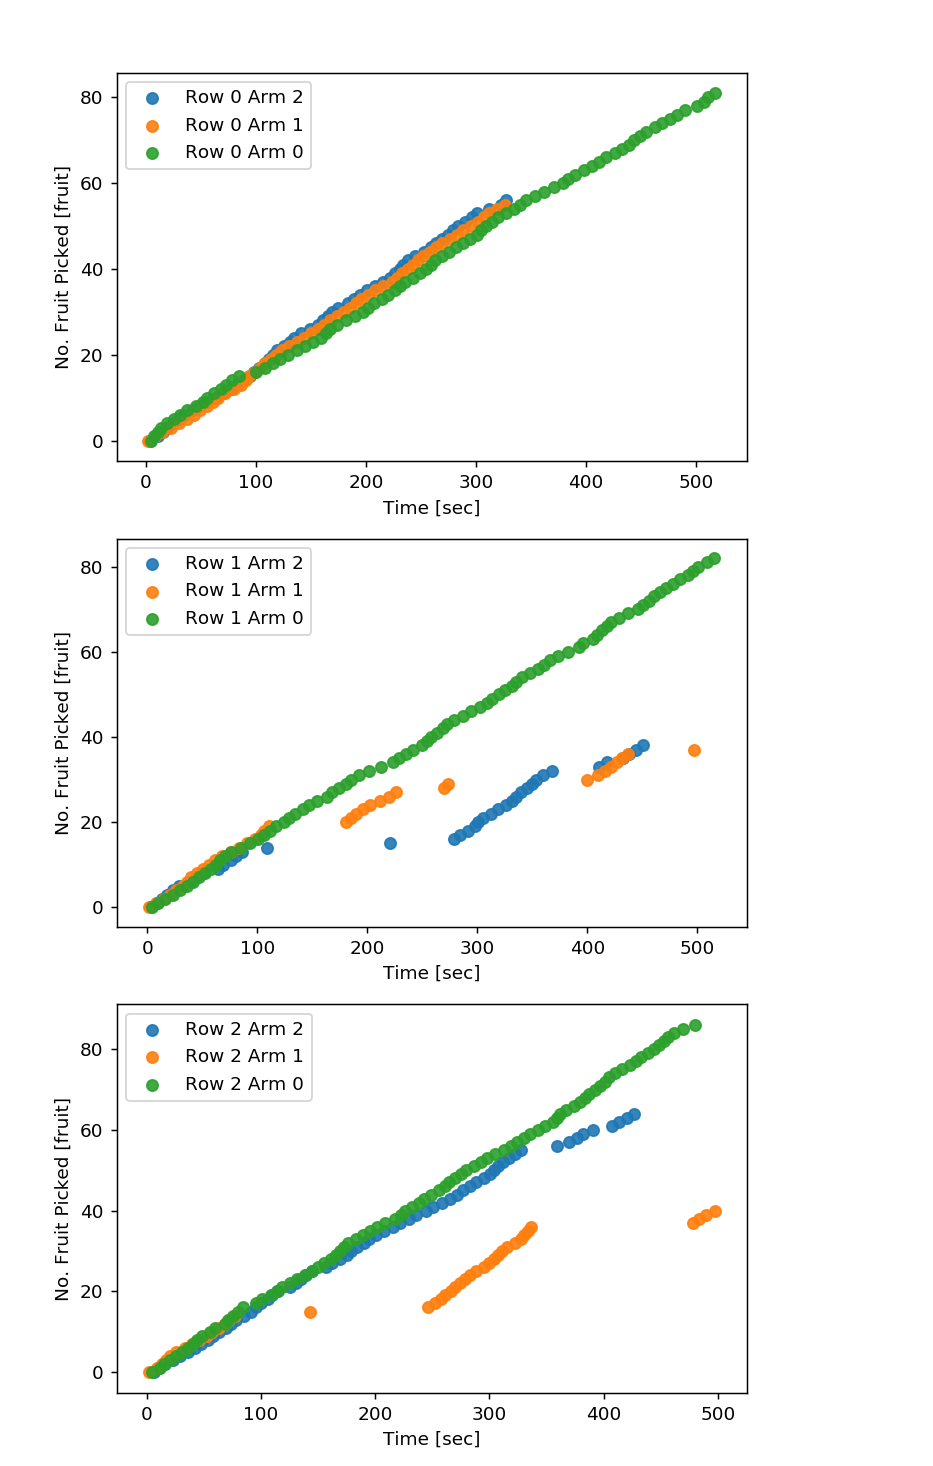

In [16]:
# Plot time versus number of fruit picked per arm
fig, ax = plt.subplots(num_row, figsize=(7, 11))

for rows in range(num_row):
    for manipulators in range((num_arms-1), -1, -1):
        time_apples = np.copy(a[rows,manipulators].pickData())
        apples      = range(np.shape(time_apples)[0])

        
        arm_label = "Row "+str(rows)+" Arm "+str(manipulators)
        
        ax[rows].scatter(time_apples, apples, alpha=0.9, label=arm_label)
        ax[rows].set_xlabel("Time [sec]")
        ax[rows].set_ylabel("No. Fruit Picked [fruit]")
#         ax[rows].set_title("No. of fruit picked versus time")
        ax[rows].legend(loc='upper left', ncol=1)
        
        fig.subplots_adjust(bottom=0.05, top=0.95, right=0.8)
        
        plt.show()
        
        

In [17]:
# analyze the % time each arm is in each state 
idle       = 0.
pickingyz  = 0.
pickingx   = 0.
grabbing   = 0.
retracting = 0.
unloading  = 0.

tot_num_arms = num_arms*num_row

state_step = 0

state_data = np.zeros((tot_num_arms, len(arm_states)))

# obtain the state for each arm
for time_step in arm_states:
    for arm_num in time_step:
        state_data[arm_num[0],state_step] = arm_num[1]
       
    state_step += 1
        
idle_arm   = 0.
pickyz_arm = 0.
pickx_arm  = 0.
grab_arm   = 0.
retr_arm   = 0.
unlo_arm   = 0.

row_n = 0
arm_n = 0

# for plotting
idle_plot   = []
pickyz_plot = []
pickx_plot  = []
grab_plot   = []
retr_plot   = []
unlo_plot   = []


# for each arm take the state obtained using state_data, determine the state at each time point for each arm 
for i in range(tot_num_arms):
    for x in state_data[i]:
        if x == 0:
            idle_arm   += 1
        elif x == 1:
            pickyz_arm += 1
        elif x == 2:
            pickx_arm  += 1
        elif x == 3:
            grab_arm   += 1
        elif x == 4:
            retr_arm   += 1
        elif x == 5:
            unlo_arm   += 1
    
    # add them all together so that percentages can be calculated
    total = idle_arm + pickyz_arm + pickx_arm + grab_arm + retr_arm + unlo_arm
    
    # get the total amount of time all arms spent in each state
    idle       += idle_arm
    pickingyz  += pickyz_arm
    pickingx   += pickx_arm
    grabbing   += grab_arm
    retracting += retr_arm
    unloading  += unlo_arm
    
    # append the current arm's data to the plotting list
    idle_plot.append(idle_arm)
    pickyz_plot.append(pickyz_arm)
    pickx_plot.append(pickx_arm)
    grab_plot.append(grab_arm)
    retr_plot.append(retr_arm)
    unlo_plot.append(unlo_arm)
    
    arm_n += 1
    
    # used to detemine which row corresponds to the specific arm
    if i%num_row == 0:
        row_n = math.floor(i/num_row)
        arm_n = 0
        
#     print("Arm", arm_n, "in row", row_n)
#     print("Idle:", idle_arm, "[unitless], Picking:", pick_arm, "[unitless], Retracting:", retr_arm, "[unitless], Unloading:", unlo_arm, "[unitless]")
#     print("Idle: {0:.4f}".format(idle_arm/total*100), "[%], Picking: {0:.4f}".format(pick_arm/total*100), "[%], Retracting: {0:.4f}".format(retr_arm/total*100), "[%], Unloading: {0:.4f}".format(unlo_arm/total*100), "[%]")
#     print("")
    
    # reset for the next run
    idle_arm   = 0.
    pickyz_arm = 0.
    pickx_arm  = 0.
    grab_arm   = 0.
    retr_arm   = 0.
    unlo_arm   = 0.


In [18]:
## Functions to add grouping into the arm state percentage plot (and other future plots)
# https://stackoverflow.com/questions/19184484/how-to-add-group-labels-for-bar-charts-in-matplotlib

def mk_groups(data):
    # function takes a dictionary (or anything with an items() method, like collections.OrderedDict) and converts it to a data format that is then used to create the chart. It is basically a list
    try:
        newdata = data.items()
    except:
        return

    thisgroup = []
    groups = []
    for key, value in newdata:
        newgroups = mk_groups(value)
        if newgroups is None:
            thisgroup.append((key, value))
        else:
            thisgroup.append((key, len(newgroups[-1])))
            if groups:
                groups = [g + n for n, g in zip(newgroups, groups)]
            else:
                groups = newgroups
    return [thisgroup] + groups

def add_line(ax, xpos, ypos):
    # creates a vertical line in the subplot at the specified positions (in axes coordinates)
    line = plt.Line2D([xpos, xpos], [ypos + .1, ypos],
                      transform=ax.transAxes, color='black')
    line.set_clip_on(False)
    ax.add_line(line)

def label_group_bar(ax, data):
    # takes a dictionary and creates the subplot with the labels beneath
    groups = mk_groups(data)
    xy = groups.pop()
    x, y = zip(*xy)
    ly = len(y)
    xticks = range(1, ly + 2)

    ax.set_xticks(xticks)
    ax.set_xticklabels(x)
    ax.set_xlim(.5, ly + .5)

    scale = 1. / ly
    for pos in range(ly + 1):
        add_line(ax, pos * scale, -.1)
        
    ypos = -.2
    while groups:
        group = groups.pop()
        pos = 0
        for label, rpos in group:
            lxpos = (pos + .5 * rpos) * scale
            ax.text(lxpos, ypos, label, ha='center', transform=ax.transAxes)
            add_line(ax, pos*scale, ypos)
            pos += rpos
        add_line(ax, pos*scale, ypos)
        ypos -= .1



<IPython.core.display.Javascript object>


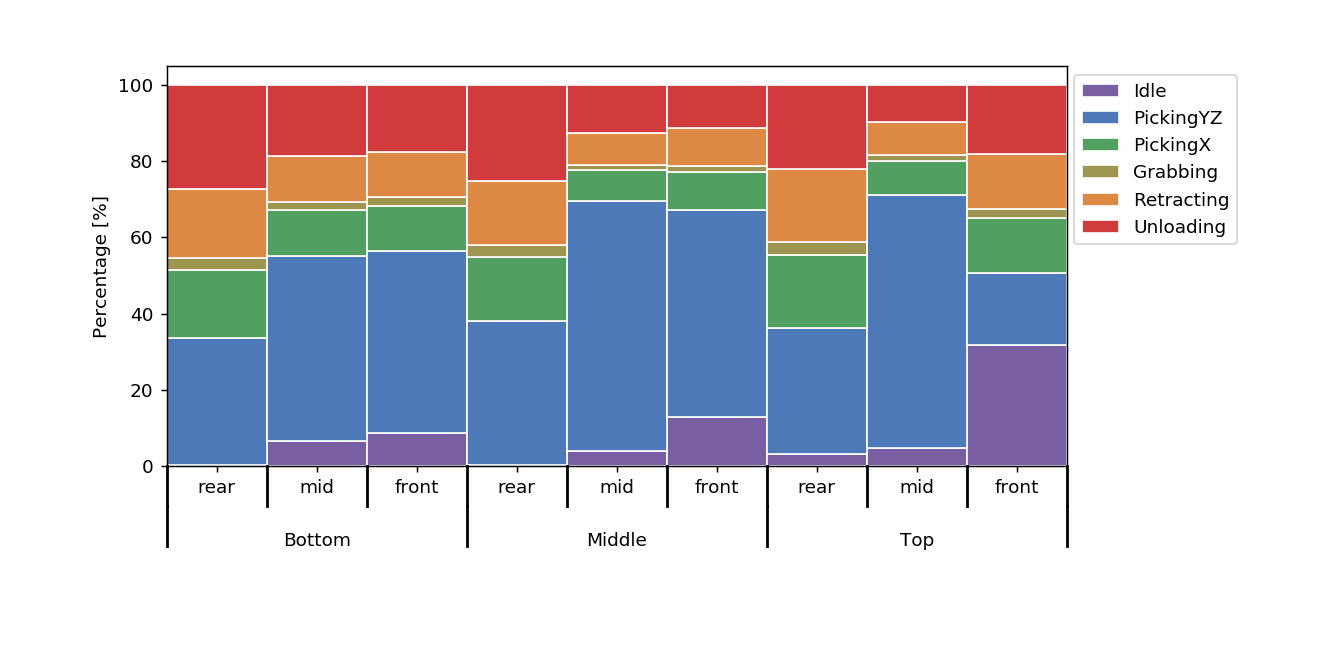

In [19]:
# % stacked bar plot
## https://chrisalbon.com/python/data_visualization/matplotlib_percentage_stacked_bar_plot/

data = {'Bottom':
           {'rear':0,
            'mid':1,
            'front':2
           },
#         'Middle Bt':
#            {'rear':0,
#             'mid':1,
#             'front':2
#            },
#         'Middle Top':
#            {'rear':0,
#             'mid':1,
#             'front':2
#            },
        'Middle':
           {'rear':0,
            'mid':1,
            'front':2
           },
        'Top':
           {'rear':0,
            'mid':1,
            'front':2
           },
       }



# Create a figure with a single subplot
f, ax = plt.subplots(1, figsize=(10,5))

# Set bar width at 1
bar_width = 1

# positions of the left bar-boundaries
bar_l = [i for i in range(1,len(idle_plot)+1)] 

# positions of the x-axis ticks (center of the bars as bar labels)
tick_pos = [i+(bar_width/2) for i in bar_l] 
# print(tick_pos)

# Create the total steps per state
totals = [i+j+k+l+m+n for i,j,k,l,m,n in zip(idle_plot, pickyz_plot, pickx_plot, grab_plot, retr_plot, unlo_plot)]

# Create the percentage of the total steps for idle state
per_idle = [i / j * 100 for  i,j in zip(idle_plot, totals)]
# Create the percentage of the total steps for pickingyz state
per_pickyz = [i / j * 100 for  i,j in zip(pickyz_plot, totals)]
# Create the percentage of the total steps for pickingx state
per_pickx = [i / j * 100 for  i,j in zip(pickx_plot, totals)]
# Create the percentage of the total steps for grabbing state
per_grab = [i / j * 100 for  i,j in zip(grab_plot, totals)]
# Create the percentage of the total steps for retracting state
per_retr = [i / j * 100 for  i,j in zip(retr_plot, totals)]
# Create the percentage of the total steps for unloading state
per_unlo = [i / j * 100 for  i,j in zip(unlo_plot, totals)]

# Create a bar chart in position bar_1
ax.bar(bar_l, 
       # using idle data
       per_idle, 
       # labeled 
       label='Idle', 
       # with alpha
       alpha=0.9, 
       # with color
       color='#6B4C9A',
       # with bar width
       width=bar_width,
       # with border color
       edgecolor='white'
       )

ax.bar(bar_l, 
       # using picking data
       per_pickyz, 
       # with per_idle
       bottom=per_idle, 
       # labeled 
       label='PickingYZ', 
       # with alpha
       alpha=0.9, 
       # with color
       color='#396AB1', 
       # with bar width
       width=bar_width,
       # with border color
       edgecolor='white'
       )

ax.bar(bar_l, 
       # using picking data
       per_pickx, 
       # with per_idle
       bottom=[i+j for i,j in zip(per_idle, per_pickyz)], 
       # labeled 
       label='PickingX', 
       # with alpha
       alpha=0.9, 
       # with color
       color='#3E9651', 
       # with bar width
       width=bar_width,
       # with border color
       edgecolor='white'
       )

ax.bar(bar_l, 
       # using picking data
       per_grab, 
       # with per_idle
       bottom=[i+j+k for i,j,k in zip(per_idle, per_pickyz, per_pickx)], 
       # labeled 
       label='Grabbing', 
       # with alpha
       alpha=0.9, 
       # with color
       color='#948B3D', 
       # with bar width
       width=bar_width,
       # with border color
       edgecolor='white'
       )

# Create a bar chart in position bar_1
ax.bar(bar_l, 
       # using retracting data
       per_retr, 
       # with per_idle and per_pick on bottom
       bottom=[i+j+k+l for i,j,k,l in zip(per_idle, per_pickyz, per_pickx, per_grab)], 
       # labeled 
       label='Retracting',
       # with alpha
       alpha=0.9, 
       # with color
       color='#DA7C30', 
       # with bar width
       width=bar_width,
       # with border color
       edgecolor='white'
       )

# Create a bar chart in position bar_1
ax.bar(bar_l, 
       # using retracting data
       per_unlo, 
       # with all other percents on bottom
       bottom=[i+j+k+l+m for i,j,k,l,m in zip(per_idle, per_pickyz, per_pickx, per_grab, per_retr)], 
       # labeled 
       label='Unloading',
       # with alpha
       alpha=0.9, 
       # with color
       color='#CC2529', 
       # with bar width
       width=bar_width,
       # with border color
       edgecolor='white'
       )


ax.set_ylabel("Percentage [%]")

# grouping x-axis values
label_group_bar(ax, data)
f.subplots_adjust(bottom=0.3, top=0.9, right=0.8)
# f.subplots_adjust()

# rotate axis labels
# plt.setp(plt.gca().get_xticklabels(), rotation=90, horizontalalignment='right')

# create legend outside of plot
# see https://stackoverflow.com/questions/4700614/how-to-put-the-legend-out-of-the-plot/43439132#43439132
ax.legend(bbox_to_anchor=(1.2, 1), loc='upper right', ncol=1)

# shot plot
plt.show()

In [22]:
# total values 
idle_all = idle*dt
pickyz_all = pickingyz*dt
pickx_all = pickingx*dt
grab_all = grabbing*dt
retract_all = retracting*dt
unload_all = unloading*dt

# print("total time spent idle for all arms:", idle_all, "sec")
# print("total time spent picking in yz axis for all arms:", pickyz_all, "sec")
# print("total time spent picking in x axis for all arms:", pickx_all, "sec")
# print("total time spent grabbing fruit for all arms:", grab_all, "sec")
# print("total time spent retracting for all arms:", retract_all, "sec")
# print("total time spent unloading for all arms:", unload_all, "sec")

total_time = (idle_all + pickyz_all + pickx_all + grab_all + retract_all + unload_all) # / (num_arms*num_row_arms)

# print("total time all arms:", total_time, "sec") 
# print("Which totals internal simulator seconds multiplied by number of arms")

percent_idle    = (idle_all / total_time) * 100
percent_pickyz  = (pickyz_all / total_time) * 100
percent_pickx   = (pickx_all / total_time) * 100
percent_grab    = (grab_all / total_time) * 100
percent_retract = (retract_all / total_time) * 100
percent_unload  = (unload_all / total_time) * 100

print("For all arms:")
print("Total percent time idle:             {0:.2f}".format(percent_idle), "%")
print("Total percent picking fruit          {0:.2f}".format(percent_pickyz+percent_pickx+percent_grab), "%")
print("---------------------------------------------")
print("Picking fruit is broken up into:")
print("Total percent time picking in y, z:  {0:.2f}".format(percent_pickyz), "%")
print("Total percent time picking in x:      {0:.2f}".format(percent_pickx), "%")
print("Total percent time grabbing fruit     {0:.2f}".format(percent_grab), "%")
print("---------------------------------------------")
print("Total percent time retracting        {0:.2f}".format(percent_retract), "%")
print("Total percent time unloading         {0:.2f}".format(percent_unload), "%")


For all arms:
Total percent time idle:             7.98 %
Total percent picking fruit          60.70 %
---------------------------------------------
Picking fruit is broken up into:
Total percent time picking in y, z:  45.14 %
Total percent time picking in x:      13.22 %
Total percent time grabbing fruit     2.34 %
---------------------------------------------
Total percent time retracting        13.23 %
Total percent time unloading         18.08 %


In [23]:
# Calculate how many goals wer given to each arm and how many of those were reached
for rows in range(num_row):
    for count in range(num_arms):
        given = a[rows, count].goals_given
        reached = a[rows, count].reached_goals
        percent_reached = (reached / given) * 100
        
        print("For arm", count, "row", rows)
        print("Number of goals given:", given, "number of goals reached:", reached)
        print("Percent reached goals: {0:.2f}".format(percent_reached), "%")
        print("")

For arm 0 row 0
Number of goals given: 91 number of goals reached: 82
Percent reached goals: 90.11 %

For arm 1 row 0
Number of goals given: 89 number of goals reached: 56
Percent reached goals: 62.92 %

For arm 2 row 0
Number of goals given: 87 number of goals reached: 57
Percent reached goals: 65.52 %

For arm 0 row 1
Number of goals given: 109 number of goals reached: 83
Percent reached goals: 76.15 %

For arm 1 row 1
Number of goals given: 114 number of goals reached: 38
Percent reached goals: 33.33 %

For arm 2 row 1
Number of goals given: 108 number of goals reached: 39
Percent reached goals: 36.11 %

For arm 0 row 2
Number of goals given: 91 number of goals reached: 87
Percent reached goals: 95.60 %

For arm 1 row 2
Number of goals given: 83 number of goals reached: 41
Percent reached goals: 49.40 %

For arm 2 row 2
Number of goals given: 78 number of goals reached: 65
Percent reached goals: 83.33 %



num runs 52001


<IPython.core.display.Javascript object>


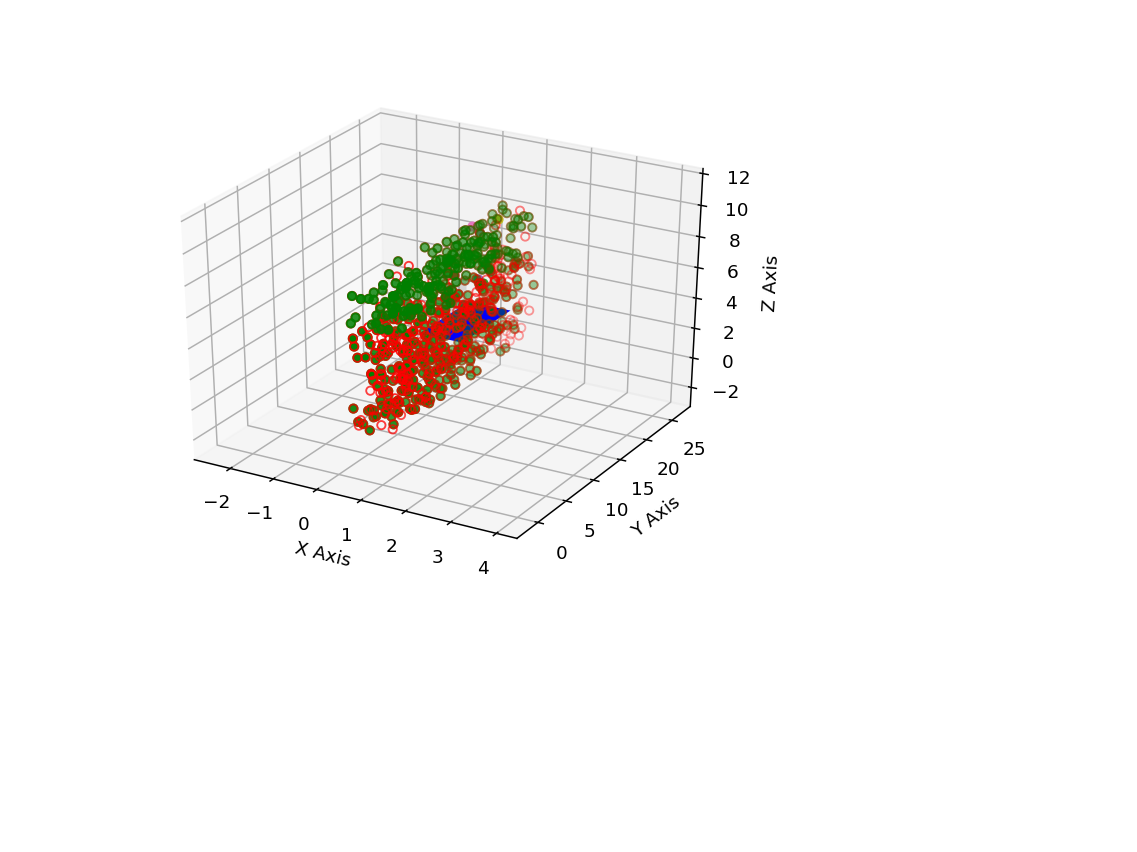

** Index grew faster than it should have? **
Index to remove: 193 in row: 2 time: 498.00999999969207
current time value of fruit_removal: 497.24999999969276
** Index grew faster than it should have? **
Index to remove: 193 in row: 2 time: 498.6099999996915
current time value of fruit_removal: 497.24999999969276
** Index grew faster than it should have? **
Index to remove: 193 in row: 2 time: 499.209999999691
current time value of fruit_removal: 497.24999999969276
** Index grew faster than it should have? **
Index to remove: 193 in row: 2 time: 499.80999999969043
current time value of fruit_removal: 497.24999999969276
** Index grew faster than it should have? **
Index to remove: 193 in row: 2 time: 500.4099999996899
current time value of fruit_removal: 497.24999999969276
** Index grew faster than it should have? **
Index to remove: 193 in row: 2 time: 501.00999999968934
current time value of fruit_removal: 497.24999999969276
** Index grew faster than it should have? **
Index to remove: 

In [24]:
## plot the vehicle's movement (add other parts as they get finished)    
print("num runs", runs)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
plt.ion() 

fig.show()
fig.canvas.draw()

ax.set_xlabel('X Axis')
ax.set_ylabel('Y Axis')
ax.set_zlabel('Z Axis')

for run in range(runs):
    time_of_loop = t[run]
    
    if run % 60 == 0:
        ax.clear()
        
        for rows in range(num_row):
            # check if any fruit was picked at this time
            try:        
                # is the if needed when there is a try? => yup, otherwise the points appear at random times
                if fruit_removal[rows][3, index_rem[rows]] < time_of_loop:
                    # add the fruit index to be "removed"
                    index_rem[rows] += 1
            except IndexError:
                print("** Index grew faster than it should have? **")
                print("Index to remove:", index_rem[rows], "in row:", rows, "time:", time_of_loop)
                print("current time value of fruit_removal:", fruit_removal[rows][3, index_rem[rows]-1])
        
        ax.scatter(fruit.sortedFruit[0,:], fruit.sortedFruit[1,:], fruit.sortedFruit[2,:], facecolors='none', edgecolors='r')
        
        for rows in range(num_row):
            ax.scatter(fruit_removal[rows][0,:index_rem[rows]], fruit_removal[rows][1,:index_rem[rows]], fruit_removal[rows][2,:index_rem[rows]], c='g', marker='o')
            
        q_vehicle = [qv0[run], qv1[run]]
        dr.drawRect(q_vehicle, width_v, length_v) # try and draw the vehicle moving along the orchard
        dr.drawFrame(left_edge[run], back_edge[run], front_edge[run], a[0,0].z_edges_f)
    
        # draw cyliders for the extending arms
        for rows in range(num_row):
            for count in range(num_arms):
                ax.scatter(a[rows,count].qax[run], a[rows,count].qay[run], a[rows,count].qaz[run])
                # need to switch this to a cylinder
                xc, yc, zc = dr.drawArmCylinder(a[rows,count].qay[run], a[rows,count].qaz[run], a[rows,count].q_f[0], a[rows,count].qax[run])
                ax.plot_surface(xc, yc, zc)


        ax.set_xlim(fruit_row_ed-3, fruit_row_tk+3)
        ax.set_zlim(fruit_row_bt-3, fruit_row_tp+3)
        
        ax.set_ylim(fruit_row_st-3, fruit_row_end+3)
        
        ax.set_xlabel('X Axis')
        ax.set_ylabel('Y Axis')
        ax.set_zlabel('Z Axis')

        fig.canvas.draw()
        time.sleep(0.005)
       
    
fig.show()



In [20]:
# need to print all the fruit that remains unpicked
miss  = 0
sched = 0 
pick  = 0

# prints all the fruit that has not been picked
for x in range(len(fruit.sortedFruit[1])):
    if fruit.sortedFruit[:,x][3] == 0: 
        miss += 1
#         print(x)
    elif fruit.sortedFruit[:,x][3] == 1:
        sched += 1
#         print(x)
    elif fruit.sortedFruit[:,x][3] == 2:
        pick += 1
        
# should plot the three different groups to see where they are
print("Total missed fruit:", miss)
print("Total scheduled, but not picked fruit:", sched)
print("Total picked fruit:", pick)

print("")
print("They add up to:", miss+sched+pick)
print("Total unpicked fruit:", miss+sched)

per = 100* (miss+sched) / (miss+sched+pick)

print("Percent missed fruit: {0:.2f}".format(per), "%")

Total missed fruit: 391
Total scheduled, but not picked fruit: 4
Total picked fruit: 280

They add up to: 675
Total unpicked fruit: 395
Percent missed fruit: 58.52 %
